<a href="https://colab.research.google.com/github/ayulockin/SwAV-TF/blob/master/MultiCropDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import time
import os

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

In [9]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

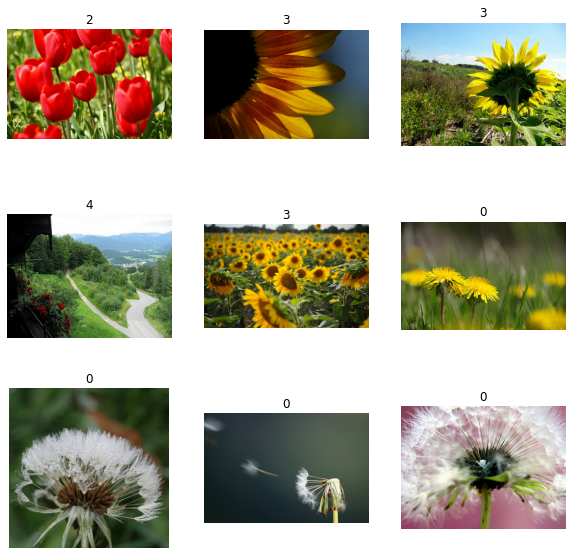

In [3]:
#Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

There are 8 views. 
* load single image - train_ds gives one image now.
* get random crops (2 with high res and 6 with low res) 
* apply random horizontal flip (p=0.5)
* apply color transformation 
  * RandomGausianBlur(p=0.5)
  * Color Distortion
    * Random color jitter(p=0.8)
    * Random grayscale(p=0.2)

In [ ]:
IMG_SHAPE = 256
BS = 64
SIZE_CROPS = [160, 96]
NUM_CROPS = [2,4]
min_scale = [0.5, 0.14] 
max_scale = [1., 0.5]
AUTO = tf.data.experimental.AUTOTUNE

# Reference: https://github.com/google-research/simclr/blob/master/data_util.py

# ************************ Augmentation Policies *******************************

@tf.function
def gaussian_blur(image, kernel_size=23, padding='SAME'):
  ## Gausian Blur
  sigma = tf.random.uniform((1,))* 1.9 + 0.1

  radius = tf.cast(kernel_size / 2, tf.int32)
  kernel_size = radius * 2 + 1
  x = tf.cast(tf.range(-radius, radius + 1), tf.float32)
  blur_filter = tf.exp(
      -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, tf.float32), 2.0)))
  blur_filter /= tf.reduce_sum(blur_filter)
  # One vertical and one horizontal filter.
  blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
  blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
  num_channels = tf.shape(image)[-1]
  blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
  blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
  expand_batch_dim = image.shape.ndims == 3
  if expand_batch_dim:
    image = tf.expand_dims(image, axis=0)
  blurred = tf.nn.depthwise_conv2d(
      image, blur_h, strides=[1, 1, 1, 1], padding=padding)
  blurred = tf.nn.depthwise_conv2d(
      blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
  if expand_batch_dim:
    blurred = tf.squeeze(blurred, axis=0)
  return blurred

@tf.function
def color_jitter(x, s=0.5):
    # Color Jitter
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_hue(x, max_delta=0.2*s)
    x = tf.clip_by_value(x, 0, 1)
    return x

@tf.function
def color_drop(x):
    # Grayscale
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

# ******************************************************************************

# *********************** Random Data Augmentation *****************************

@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)

@tf.function
def custom_augment(image, label):        
    # Random flips
    image = random_apply(tf.image.flip_left_right, image, p=0.5)
    # Randomly apply gausian blur
    image = random_apply(gaussian_blur, image, p=0.5)
    # Randomly apply transformation (color distortions) with probability p.
    image = random_apply(color_jitter, image, p=0.8)
    # Randomly apply grayscale
    image = random_apply(color_drop, image, p=0.2)

    return (image, label)

# ******************************************************************************

# *************************** Image Preprocessing ******************************

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))

    return (image, label)

# ************************** Random Crop Resize ********************************

@tf.function
def random_resize_crop(image, label, min_scale, max_scale, crop_size):
    # get the crop size for given min and max scale
    size = tf.random.uniform(shape=(1,), minval=min_scale*IMG_SHAPE, maxval=max_scale*IMG_SHAPE, dtype=tf.float32)
    size = tf.cast(size, tf.int32)[0]
    # get the crop from the image
    crop = tf.image.random_crop(image, (size,size,3))
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))

    return crop_resize, label  

# ******************************************************************************

# ************* Prepare multiple trainloaders to get multiple views ************

trainloaders = tuple()
for i, num_crop in enumerate(NUM_CROPS):
  for _ in range(num_crop):
    trainloader = (
        train_ds
        .map(preprocess_image, num_parallel_calls=AUTO)
        .shuffle(1024)
        .map(lambda x, y: random_resize_crop(x, y, min_scale[i], max_scale[i], SIZE_CROPS[i]), num_parallel_calls=AUTO)
        .map(custom_augment, num_parallel_calls=AUTO)
    )
    trainloaders+=(trainloader,)

# ******************************************************************************

# :point_down: using for debugging. Using only three dataloader for simplicity
# trainloader1 gives high res augmented view(160x160) while trainloader2 and 3 
# are giving los res augmened view(96x96). The idea is to zip these using 
# tf.data.Dataset.zip(). The output of this would be tuples. If we can shuffle 
# the order of shuffle we have (exactly) same multi-resize-crop hopefully. 

trainloader1 = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(1024)
    .map(lambda x, y: random_resize_crop(x, y, min_scale[0], max_scale[0], SIZE_CROPS[0]), num_parallel_calls=AUTO)
    .map(custom_augment, num_parallel_calls=AUTO)
)
trainloader2 = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(1024)
    .map(lambda x, y: random_resize_crop(x, y, min_scale[1], max_scale[1], SIZE_CROPS[1]), num_parallel_calls=AUTO)
    .map(custom_augment, num_parallel_calls=AUTO)
)
trainloader3 = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(1024)
    .map(lambda x, y: random_resize_crop(x, y, min_scale[1], max_scale[1], SIZE_CROPS[1]), num_parallel_calls=AUTO)
    .map(custom_augment, num_parallel_calls=AUTO)
)

In [178]:
@tf.function
def shuffle_zipped_output(a,b,c):
  # TO-DO
  return b, a, c # notice manually shuffing the order.

# zipping 
# trainloader = tf.data.Dataset.zip(trainloaders)
trainloader = tf.data.Dataset.zip((trainloader1, trainloader2, trainloader3))

# final trainloader
trainloader = (
    trainloader
    .cache()
    .shuffle(1024, reshuffle_each_iteration=True)
    .batch(64)
    .map(shuffle_zipped_output, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [179]:
(im1,_),(im2,_),(im3,_) = next(iter(trainloader))
print(im1.shape, im2.shape, im3.shape)

(64, 160, 160, 3) (64, 96, 96, 3) (64, 96, 96, 3)


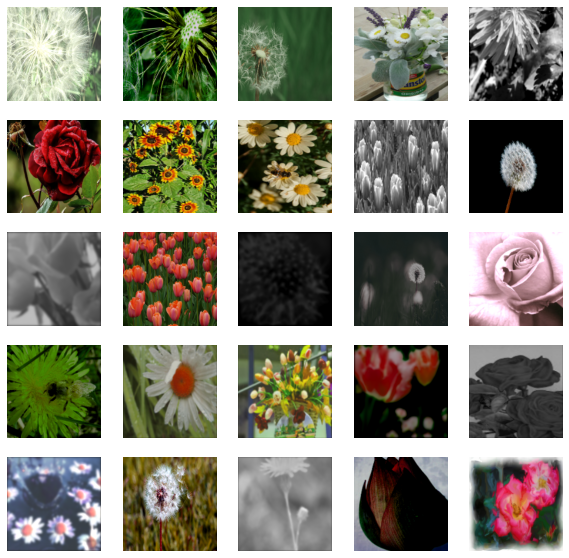

In [143]:
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(im1[n])
    plt.axis('off')

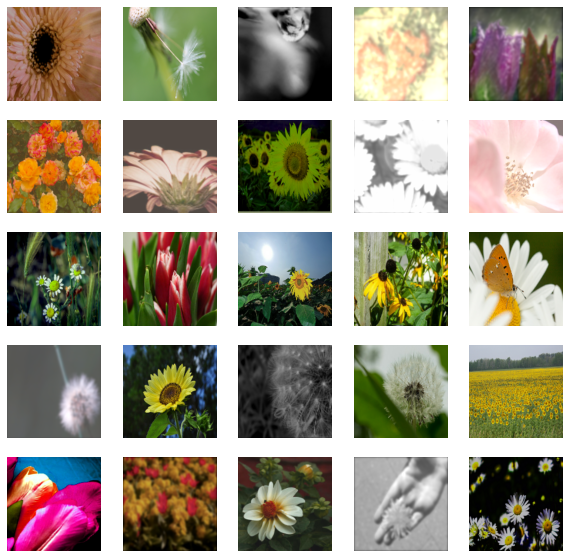

In [170]:
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(im2[n])
    plt.axis('off')

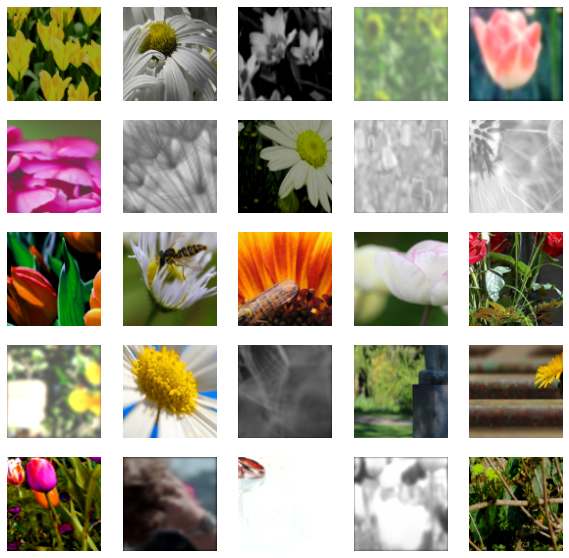

In [171]:
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(im3[n])
    plt.axis('off')